In [1]:
import cv2
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import numpy as np
import matplotlib.pyplot as plt
from pylab import savefig
%matplotlib inline

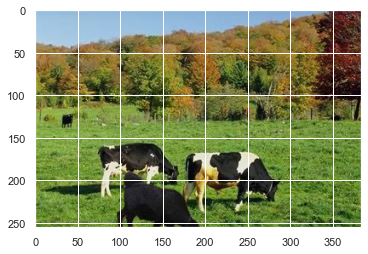

In [3]:
img = plt.imread("./3.jpg")
img = img.astype('float32') / 255.
plt.imshow(img)

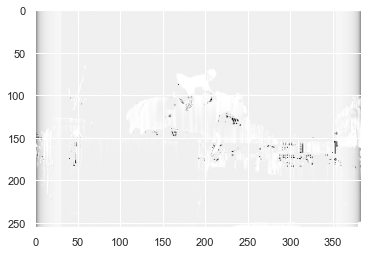

In [35]:
error = np.load("./2_mask.npy")
plt.imshow(error, cmap="gray")

In [36]:
error

array([[0.        , 0.5       , 0.66666667, ..., 0.66666667, 0.5       ,
        0.        ],
       [0.        , 0.5       , 0.66666667, ..., 0.66666667, 0.5       ,
        0.        ],
       [0.        , 0.5       , 0.66666667, ..., 0.66666667, 0.5       ,
        0.        ],
       ...,
       [0.        , 0.5       , 0.66666667, ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.5       , 0.66666667, ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.5       , 0.66666667, ..., 1.        , 1.        ,
        1.        ]])

<AxesSubplot:>

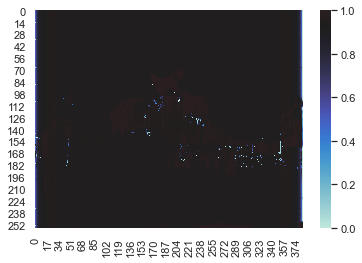

In [37]:
sns.heatmap(error, center=np.mean(error))